# Requirements

In [ ]:
!cat /proc/meminfo | grep MemTotal


MemTotal:       53470708 kB


In [ ]:
!pip install datasets


In [ ]:
pip install emoji

In [ ]:
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from datasets import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import nltk
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')




[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preprocessing:
* Drop null values
* Ensure that 'title' and 'text' columns have 'str' data type
* Lemmatize, remove stop words and punctuations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/reddit_mental_health.csv'

# data overview
df = pd.read_csv(path)
df

,Unnamed: 0,text,title,target
0,0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1
1,1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1
2,2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1
3,3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1
4,4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1
...,...,...,...,...
5952,1183,I’ve (24M) dealt with depression/anxiety for y...,Nobody takes me seriously,4
5953,1184,"""I don't feel very good, it's like I don't be...",selfishness,4
5954,1185,"I can't sleep most of the nights, meds didn't ...",Is there any way to sleep better?,4
5955,1186,"Hi, all. I have to give a presentation at work...",Public speaking tips?,4


In [ ]:
# drop the rows with missing values
df1 = df.dropna()
df1

,Unnamed: 0,text,title,target
0,0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1
1,1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1
2,2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1
3,3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1
4,4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1
...,...,...,...,...
5952,1183,I’ve (24M) dealt with depression/anxiety for y...,Nobody takes me seriously,4
5953,1184,"""I don't feel very good, it's like I don't be...",selfishness,4
5954,1185,"I can't sleep most of the nights, meds didn't ...",Is there any way to sleep better?,4
5955,1186,"Hi, all. I have to give a presentation at work...",Public speaking tips?,4


In [ ]:
# drop the 'row number' column since it's just an identifier
df2 = df1.drop(df1.columns[0], axis=1)
df2.info()

# also note that we have a pretty balanced dataset!

<class 'pandas.core.frame.DataFrame'>
Index: 5607 entries, 0 to 5956
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5607 non-null   object
 1   title   5607 non-null   object
 2   target  5607 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 175.2+ KB


In [ ]:
df_vader=df2.copy()

In [ ]:
# change "title" and "text" columns to string datatype
df3 = df2.copy()
df3["text"] = df2["text"].astype("string")

df3.head()

,text,title,target
0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1
1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1
2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1
3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1
4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def is_emoji(char):
    return char in emoji.EMOJI_DATA  # Works with emoji v2+

def get_wordnet_pos(nltk_pos_tag):
    """
    Map NLTK POS tags to WordNet POS tags for lemmatization.
    """
    tag_mapping = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return tag_mapping.get(nltk_pos_tag[0], wordnet.NOUN)  # Default to NOUN

def preprocess_text(text):
    """
    Preprocesses the input text: Lowercasing, removing punctuation,
    tokenizing, lemmatizing, and POS tagging.
    """
    if not isinstance(text, str):  # Ensure valid string input
        return "", []

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ''.join(char for char in text if char.isalnum() or char.isspace() or is_emoji(char))  # Remove special characters (excluding emojis)
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize excessive whitespace

    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords

    if not tokens:  # If no valid tokens remain, return empty text
        return "", []

    pos_tags = nltk.pos_tag(tokens)  # Apply POS tagging
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) for word, pos in pos_tags]
    processed_text_str = ' '.join(lemmatized_tokens)

    #processed_text = ' '.join(lemmatized_tokens)
    return lemmatized_tokens, processed_text_str # Return lemmatized text and POS tags



In [ ]:
# Apply preprocessing
df3[['processed_text', 'processed_text_str']] = df3['text'].apply(preprocess_text).apply(pd.Series)


In [ ]:
df3['processed_text_str'] = df3['processed_text_str'].astype(str)
df3['processed_text'] = df3['processed_text'].apply(lambda x: x if isinstance(x, list) else [])
print(type(df3['processed_text'].iloc[0]))  # Should be <class 'list'>
print(all(isinstance(doc, list) for doc in df3['processed_text']))  # Should return True


<class 'list'>
True


# EDA

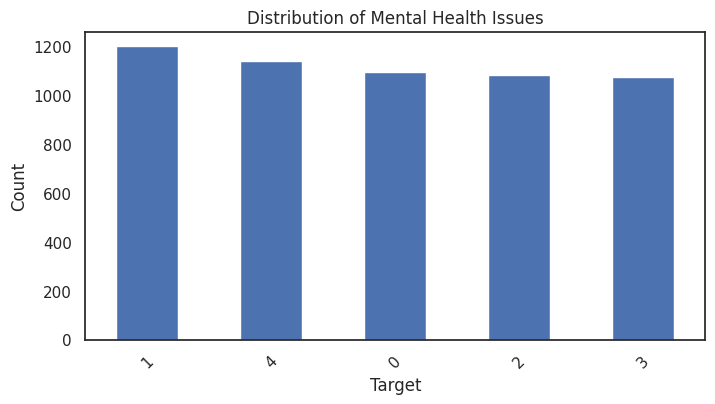

In [ ]:
# Distribution of Target Values
plt.figure(figsize=(8,4))
df3['target'].value_counts().plot(kind='bar')
plt.title("Distribution of Mental Health Issues")
plt.xlabel("Target")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

==> Distribution of target values shows that the dataset is quite balanced


## BOW

In [ ]:
vectorizer = CountVectorizer()
bow_vectorizer_title = CountVectorizer(max_features=2000)
bow_vectorizer_text = CountVectorizer(max_features=5000)

# Fit and transform
X_bow_title = bow_vectorizer_title.fit_transform(df3["processed_text_str"].fillna(""))
X_bow_text = bow_vectorizer_text.fit_transform(df3["processed_text_str"].fillna(""))

# Extract feature names
bow_feature_names_title = bow_vectorizer_title.get_feature_names_out()
bow_feature_names_text = bow_vectorizer_text.get_feature_names_out()

bow_word_counts_title = np.asarray(X_bow_title.sum(axis=0)).flatten()
bow_word_counts_text = np.asarray(X_bow_text.sum(axis=0)).flatten()

# Create DataFrames for word frequencies
df_bow_freq_title = pd.DataFrame({
    "Word": bow_feature_names_title,
    "Frequency": bow_word_counts_title
}).sort_values(by="Frequency", ascending=False)

df_bow_freq_text = pd.DataFrame({
    "Word": bow_feature_names_text,
    "Frequency": bow_word_counts_text
}).sort_values(by="Frequency", ascending=False)


## TFIDF

In [ ]:
tfidf_vectorizer_title = TfidfVectorizer(max_features=2000)
tfidf_vectorizer_text = TfidfVectorizer(max_features=5000)

X_tfidf_title = tfidf_vectorizer_title.fit_transform(df3["processed_text_str"].fillna(""))
X_tfidf_text = tfidf_vectorizer_text.fit_transform(df3["processed_text_str"].fillna(""))

tfidf_feature_names_title = tfidf_vectorizer_title.get_feature_names_out()
tfidf_feature_names_text = tfidf_vectorizer_text.get_feature_names_out()

# Compute TF-IDF importance (mean value for each word across all documents)
tfidf_word_importance_title = np.asarray(X_tfidf_title.mean(axis=0)).flatten()
tfidf_word_importance_text = np.asarray(X_tfidf_text.mean(axis=0)).flatten()

# Create DataFrames for TF-IDF importance comparison
df_tfidf_freq_title = pd.DataFrame({
    "Word": tfidf_feature_names_title,
    "Importance": tfidf_word_importance_title
}).sort_values(by="Importance", ascending=False)

df_tfidf_freq_text = pd.DataFrame({
    "Word": tfidf_feature_names_text,
    "Importance": tfidf_word_importance_text
}).sort_values(by="Importance", ascending=False)

In [ ]:
# Define the target variable
target_values = df3["target"].unique()

# Dictionary to store TF-IDF results for each class
tfidf_results = {}

# Compute TF-IDF for each target class separately
for target in target_values:
    df_subset = df3[df3["target"] == target]

    tfidf_vectorizer_text = TfidfVectorizer(max_features=5000)
    X_tfidf_text = tfidf_vectorizer_text.fit_transform(df_subset["processed_text_str"].fillna(""))

    tfidf_feature_names_text = tfidf_vectorizer_text.get_feature_names_out()
    tfidf_word_importance_text = np.asarray(X_tfidf_text.mean(axis=0)).flatten()

    df_tfidf_freq_text = pd.DataFrame({
        "Word": tfidf_feature_names_text,
        "Importance": tfidf_word_importance_text
    }).sort_values(by="Importance", ascending=False)

    tfidf_results[target] = df_tfidf_freq_text

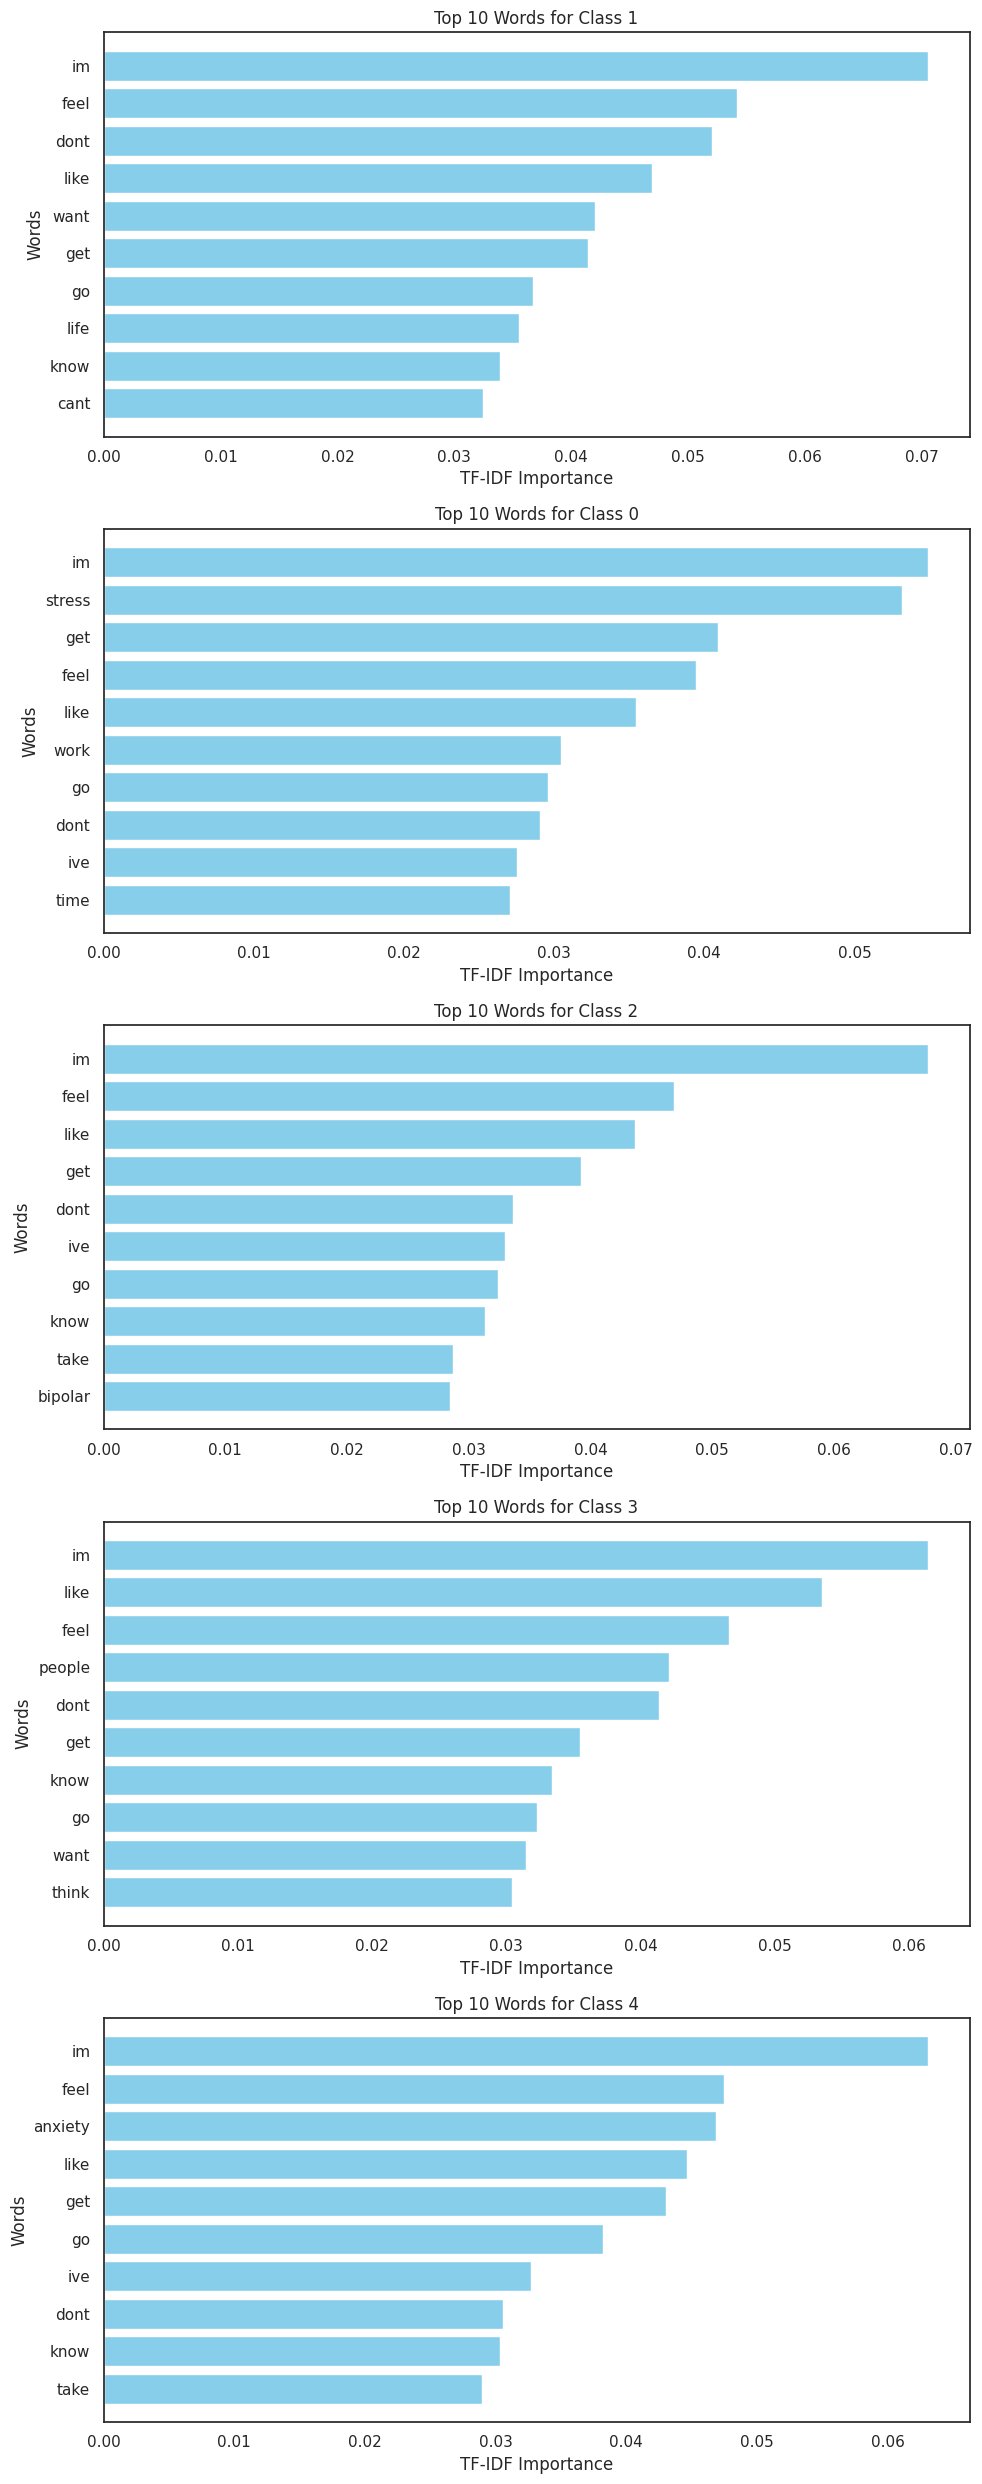

In [ ]:
def visualize_tfidf_results(tfidf_results, top_n=10):
    """
    Visualizes the top words for each target class based on their TF-IDF importance.

    Parameters:
    tfidf_results (dict): Dictionary where keys are target classes and values are DataFrames with words and importance.
    top_n (int): Number of top words to visualize for each class.
    """

    # Create subplots for visualization
    fig, axes = plt.subplots(len(tfidf_results), 1, figsize=(10, 5 * len(tfidf_results)))

    if len(tfidf_results) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one class

    # Plot bar charts for each target class
    for ax, (target, df) in zip(axes, tfidf_results.items()):
        df_top = df.head(top_n)
        ax.barh(df_top["Word"], df_top["Importance"], color='skyblue')
        ax.set_xlabel("TF-IDF Importance")
        ax.set_ylabel("Words")
        ax.set_title(f"Top {top_n} Words for Class {target}")
        ax.invert_yaxis()  # Invert y-axis for better readability

    plt.tight_layout()
    plt.show()

# Call the function to visualize the results
visualize_tfidf_results(tfidf_results, top_n=10)

## BOW vs TFIDF


*  Most frequent words: "im," "feel," "like," "get," "dont”​

* BoW captures frequently used words but does not distinguish between common language and meaningful terms.​

* TF-IDF did a better job at filtering out generic words and highlighting topic-specific words such as "anxiety," "stress," and "cant.”

**=> TF-IDF is preferred for better insights for classification​**



In [ ]:
df_text_comparison = pd.merge(df_bow_freq_text, df_tfidf_freq_text, on="Word", how="inner")

df_text_comparison.rename(columns={"Frequency": "BoW Count", "Importance": "TF-IDF Importance"}, inplace=True)

df_text_comparison["BoW Rank"] = df_text_comparison["BoW Count"].rank(ascending=False, method="min")

df_text_comparison["TF-IDF Rank"] = df_text_comparison["TF-IDF Importance"].rank(ascending=False, method="min")

df_text_comparison = df_text_comparison.sort_values(by="TF-IDF Importance", ascending=False)

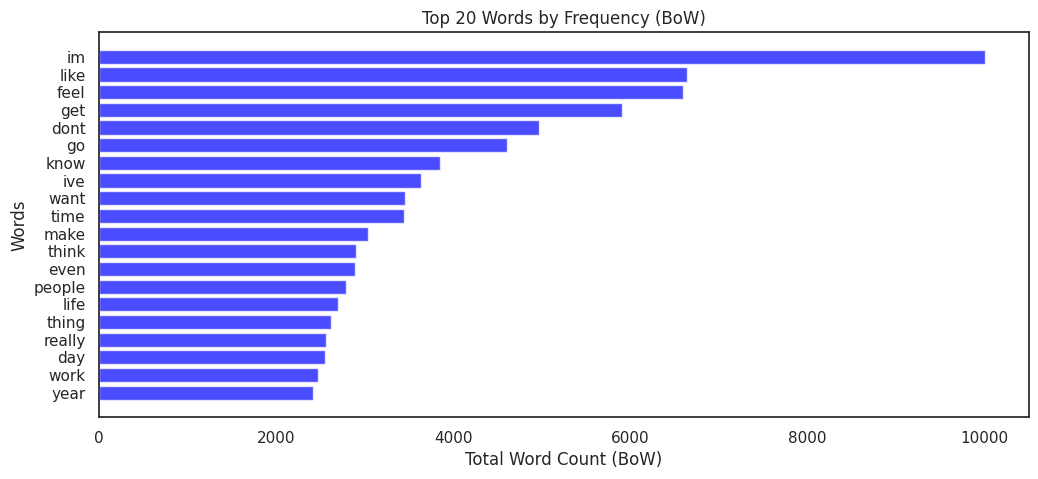

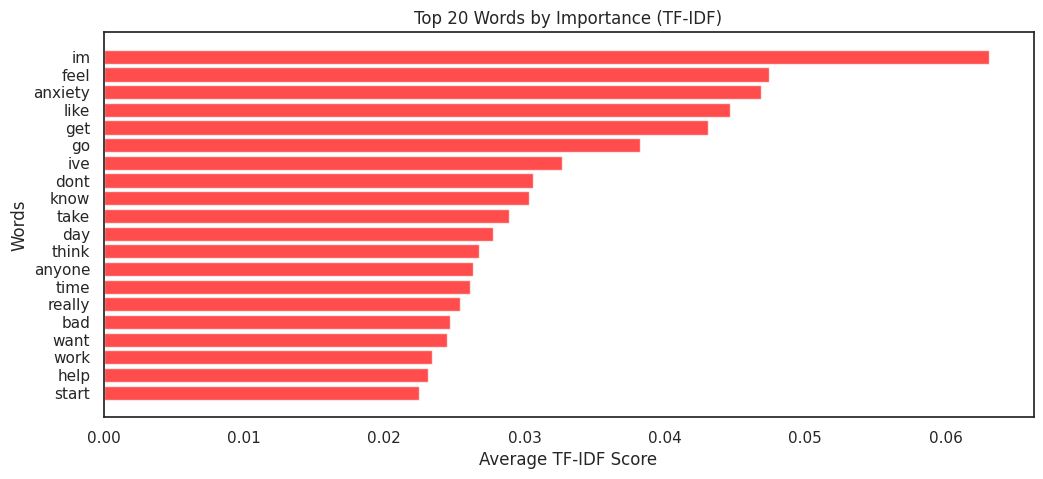

In [ ]:
top_n = 20
df_top_bow = df_text_comparison.sort_values(by="BoW Count", ascending=False).head(top_n)
df_top_tfidf = df_text_comparison.sort_values(by="TF-IDF Importance", ascending=False).head(top_n)

# Plot BoW Word Frequency
plt.figure(figsize=(12, 5))
plt.barh(df_top_bow['Word'], df_top_bow["BoW Count"], color='blue', alpha=0.7)
plt.xlabel("Total Word Count (BoW)")
plt.ylabel("Words")
plt.title("Top 20 Words by Frequency (BoW)")
plt.gca().invert_yaxis()
plt.show()

# Plot TF-IDF Word Importance
plt.figure(figsize=(12, 5))
plt.barh(df_top_tfidf['Word'], df_top_tfidf["TF-IDF Importance"], color='red', alpha=0.7)
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Words")
plt.title("Top 20 Words by Importance (TF-IDF)")
plt.gca().invert_yaxis()
plt.show()

## LDA

In [ ]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(df3['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df3['processed_text']]

# Train LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.025*"im" + 0.020*"like" + 0.017*"feel" + 0.016*"dont" + 0.013*"know" + 0.012*"people" + 0.011*"want" + 0.011*"get" + 0.010*"think" + 0.009*"go"')
(1, '0.038*"im" + 0.022*"feel" + 0.019*"like" + 0.018*"dont" + 0.013*"get" + 0.012*"go" + 0.012*"cant" + 0.010*"life" + 0.009*"want" + 0.009*"even"')
(2, '0.015*"get" + 0.014*"im" + 0.012*"like" + 0.011*"go" + 0.009*"year" + 0.009*"work" + 0.009*"feel" + 0.008*"want" + 0.008*"time" + 0.008*"dont"')
(3, '0.019*"im" + 0.018*"anxiety" + 0.016*"get" + 0.013*"ive" + 0.012*"feel" + 0.012*"go" + 0.012*"take" + 0.010*"day" + 0.009*"like" + 0.009*"start"')
(4, '0.014*"feel" + 0.011*"like" + 0.010*"body" + 0.005*"stress" + 0.005*"anyone" + 0.005*"feeling" + 0.005*"else" + 0.004*"brain" + 0.004*"mania" + 0.004*"anxiety"')


In [ ]:
# Assign dominant topic to each document
def get_dominant_topic(lda_model, corpus):
    topics = []
    for row in lda_model[corpus]:  # Get topic distribution for each document
        dominant_topic = sorted(row, key=lambda x: x[1], reverse=True)[0][0]  # Get topic with highest probability
        topics.append(dominant_topic)
    return topics

# Get dominant topics
df3['dominant_topic'] = get_dominant_topic(lda_model, corpus)

# Define topic labels
topic_labels = {
    0: "Personal Feelings & Emotional States",
    1: "Social Interactions & Relationships",
    2: "Stress & Anxiety Management",
    3: "Life Decisions & Uncertainty",
    4: "Mental Health & Medication"
}

# Assign topic names
df3['topic_name'] = df3['dominant_topic'].map(topic_labels)

df3

,text,title,target,processed_text,processed_text_str,dominant_topic,topic_name
0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1,"[welcome, rdepressions, checkin, post, place, ...",welcome rdepressions checkin post place take m...,2,Stress & Anxiety Management
1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1,"[understand, people, reply, immediately, op, i...",understand people reply immediately op invitat...,2,Stress & Anxiety Management
2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1,"[anyone, else, miss, physical, touch, crave, b...",anyone else miss physical touch crave badly,0,Personal Feelings & Emotional States
3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1,"[im, ashamed, everyone, everything, feel, far,...",im ashamed everyone everything feel far away e...,0,Personal Feelings & Emotional States
4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1,"[really, need, friend, dont, even, single, bes...",really need friend dont even single best frien...,0,Personal Feelings & Emotional States
...,...,...,...,...,...,...,...
5952,I’ve (24M) dealt with depression/anxiety for y...,Nobody takes me seriously,4,"[ive, dealt, depressionanxiety, year, use, gre...",ive dealt depressionanxiety year use great peo...,2,Stress & Anxiety Management
5953,"""I don't feel very good, it's like I don't be...",selfishness,4,"[dont, feel, good, like, dont, belong, world, ...",dont feel good like dont belong world dont thi...,0,Personal Feelings & Emotional States
5954,"I can't sleep most of the nights, meds didn't ...",Is there any way to sleep better?,4,"[cant, sleep, night, med, didnt, help]",cant sleep night med didnt help,3,Life Decisions & Uncertainty
5955,"Hi, all. I have to give a presentation at work...",Public speaking tips?,4,"[hi, give, presentation, work, next, week, min...",hi give presentation work next week minute lon...,3,Life Decisions & Uncertainty


<Figure size 1200x600 with 0 Axes>

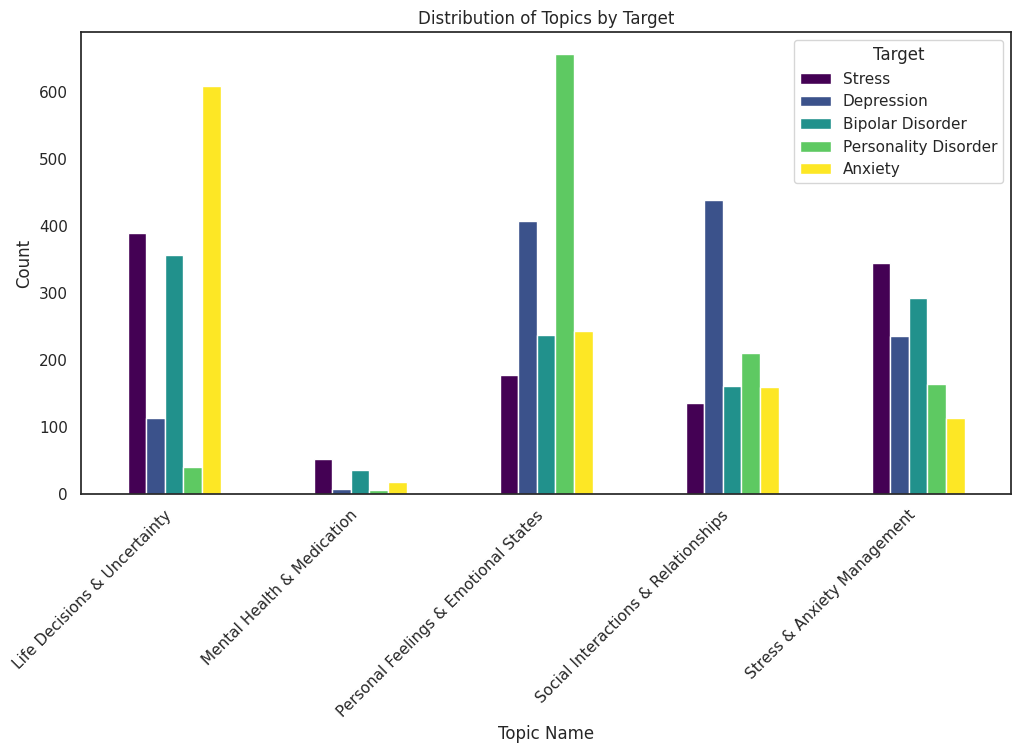

In [ ]:
# Plot the bar chart with separate bars for each target
import matplotlib.pyplot as plt

# Define target labels
target_labels = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar Disorder",
    3: "Personality Disorder",
    4: "Anxiety"
}

# Group by topic and target
topic_target_counts = df3.groupby(['topic_name', 'target']).size().unstack()

# Rename legend labels
topic_target_counts.rename(columns=target_labels, inplace=True)

plt.figure(figsize=(12, 6))
topic_target_counts.plot(kind='bar', colormap='viridis', figsize=(12,6))

# Customize labels and title
plt.xlabel("Topic Name")
plt.ylabel("Count")
plt.title("Distribution of Topics by Target")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Target")

# Show plot
plt.show()

## VADER:

*   Mostly neutral sentiment​

* Across categories, positive, negative, and compound sentiments vary slightly​

* No extreme polarity differences.



In [ ]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(post):
    sentiment = sia.polarity_scores(post)
    return sentiment['pos'], sentiment['neg'], sentiment['neu'], sentiment['compound']

df_vader['text_pos'], df_vader['text_neg'], df_vader['text_neu'], df_vader['text_compound'] = zip(*df_vader['text'].apply(get_vader_sentiment))
df_vader['title_pos'], df_vader['title_neg'], df_vader['title_neu'], df_vader['title_compound'] = zip(*df_vader['title'].apply(get_vader_sentiment))

df_vader.to_csv('reddit_posts_vader.csv', index=False)

<ipython-input-323-87b2b446eeff>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-323-87b2b446eeff>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-323-87b2b446eeff>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-323-87b2b446eeff>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




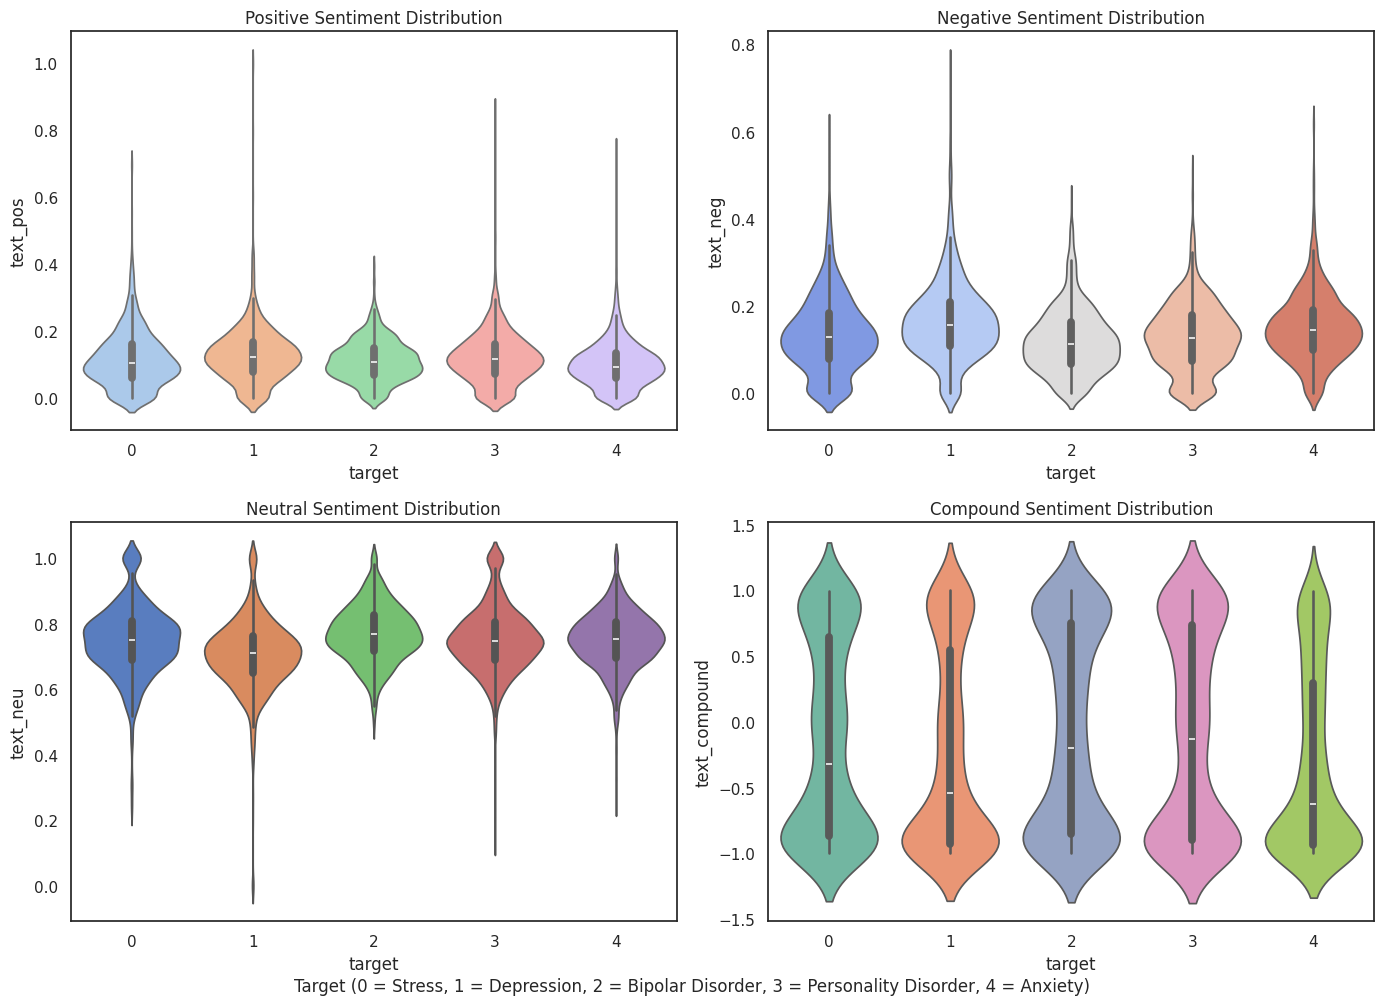

In [ ]:
# Set figure size
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# Create violin plots for each sentiment score type
sns.violinplot(x=df_vader['target'], y=df_vader['text_pos'], palette="pastel", ax=axes[0,0])
axes[0,0].set_title("Positive Sentiment Distribution")

sns.violinplot(x=df_vader['target'], y=df_vader['text_neg'], palette="coolwarm", ax=axes[0,1])
axes[0,1].set_title("Negative Sentiment Distribution")

sns.violinplot(x=df_vader['target'], y=df_vader['text_neu'], palette="muted", ax=axes[1,0])
axes[1,0].set_title("Neutral Sentiment Distribution")

sns.violinplot(x=df_vader['target'], y=df_vader['text_compound'], palette="Set2", ax=axes[1,1])
axes[1,1].set_title("Compound Sentiment Distribution")

fig.text(0.5, 0.0, 'Target (0 = Stress, 1 = Depression, 2 = Bipolar Disorder, 3 = Personality Disorder, 4 = Anxiety)', ha='center', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()



# Feature Extraction

## LDA

In [ ]:
# Get LDA Topic Distributions
def get_lda_features(lda_model, corpus, num_topics):
    features = np.zeros((len(corpus), num_topics))
    for i, doc in enumerate(corpus):
        for topic, prob in lda_model.get_document_topics(doc, minimum_probability=0):
            features[i, topic] = prob
    return features

lda_features = get_lda_features(lda_model, corpus, 5)

lda_df = pd.DataFrame(lda_features, columns=[f"topic_{i}" for i in range(5)])
lda_df.index = df3.index
df3 = pd.concat([df3, lda_df], axis=1)



## BERT Embeddings

In [ ]:
# Load the pre-trained BERT tokenizer and model.
# We use BertModel (without a classification head) for feature extraction.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode to ensure that dropout and other training-specific layers are deactivated

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Parameters for tokenization
max_length = 256  # Adjust as needed
batch_size = 8   # Adjust batch size based on your hardware

# Tokenize all texts
texts = df3["text"].tolist()
labels = df3["target"].tolist()

# Tokenize with padding and truncation. Setting return_tensors="pt" to get PyTorch tensors.
encoded_inputs = tokenizer(texts,
                           padding=True,
                           truncation=True,
                           max_length=max_length,
                           return_tensors='pt')

In [ ]:
# Create a PyTorch dataset and DataLoader for batching.
dataset = TensorDataset(encoded_inputs['input_ids'],
                        encoded_inputs['attention_mask'],
                        torch.tensor(labels))
dataloader = DataLoader(dataset, batch_size=batch_size)

# Initialize a list to hold embeddings and corresponding labels.
all_embeddings = []
all_labels = []

# Disable gradient calculation for inference.
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Generating BERT Embeddings"):
        input_ids, attention_mask, batch_labels = batch

        # Get model outputs. outputs.last_hidden_state has shape (batch_size, sequence_length, hidden_size)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the embedding corresponding to the [CLS] token (first token)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)

        # Append to our list (move to CPU and convert to numpy array)
        all_embeddings.append(cls_embeddings.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Stack all embeddings into a single NumPy array.
X = np.vstack(all_embeddings)  # Shape: (num_samples, hidden_size)
y = np.array(all_labels)

Generating BERT Embeddings:   0%|          | 0/701 [00:00<?, ?it/s]

In [ ]:
X.shape

(5607, 768)

In [ ]:
np.save("X_bert.npy", X)
np.save("y_bert.npy", y)

from google.colab import files

#files.download("X_bert.npy")
#files.download("y_bert.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Modeling:
Below are the 4 ML models that we experiment with:


*   Naive Bayes: computationally efficient, produces good performance on text classification tasks, however, there are some limitations in capturing contexts and handling rare words.
*   SVM: handles high dimensional data efficiently and works well with small to medium datasets (~ 10000 rows).
*   Random Forest: Works efficiently with high-dimensional data due to feature selection during training.
*   KNN: Easy to interpret, handles high dimensional data well (with cosine similarity), a good option for classification tasks with few classes.

and 2 feature combination approaches:
* TFIDF & LDA
* BERT & LDA



## Features: TFIDF & LDA

### Train Test Split

In [ ]:
df4 = df3.copy()

In [ ]:
df4 = df4.drop(columns=['title', 'text', 'processed_text',
                        'dominant_topic','topic_name'])

In [ ]:
df4.to_csv('/content/drive/MyDrive/df4.csv', index=False)

In [ ]:
#df4 = pd.read_csv('/content/drive/MyDrive/df4.csv')

In [ ]:
df4

,target,processed_text_str,topic_0,topic_1,topic_2,topic_3,topic_4
0,1,welcome rdepressions checkin post place take m...,0.025174,0.971842,0.000990,0.000993,0.001000
1,1,understand people reply immediately op invitat...,0.788303,0.210148,0.000515,0.000515,0.000520
2,1,anyone else miss physical touch crave badly,0.025296,0.025227,0.300132,0.025312,0.624033
3,1,im ashamed everyone everything feel far away e...,0.002222,0.060307,0.002218,0.002229,0.933025
4,1,really need friend dont even single best frien...,0.007031,0.007081,0.007017,0.007054,0.971816
...,...,...,...,...,...,...,...
5952,4,ive dealt depressionanxiety year use great peo...,0.001191,0.513389,0.120766,0.244393,0.120261
5953,4,dont feel good like dont belong world dont thi...,0.002047,0.002082,0.002052,0.002060,0.991760
5954,4,cant sleep night med didnt help,0.029019,0.029118,0.029177,0.883369,0.029316
5955,4,hi give presentation work next week minute lon...,0.005542,0.005532,0.005592,0.977751,0.005583


In [ ]:
y = df4['target']

# Train-test split
df_train, df_test, y_train, y_test = train_test_split(df4, y, test_size=0.2, random_state=42)

#### TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_train = tfidf_vectorizer.fit_transform(df_train['processed_text_str'])
tfidf_test = tfidf_vectorizer.transform(df_test['processed_text_str'])

# Step 2: Extract LDA topic features
lda_train = df_train[[f"topic_{i}" for i in range(5)]].values
lda_test = df_test[[f"topic_{i}" for i in range(5)]].values

from sklearn.preprocessing import MinMaxScaler
# Step 3: Scale LDA features (Fit on train, transform on test)
scaler = MinMaxScaler()
lda_train_scaled = scaler.fit_transform(lda_train)
lda_test_scaled = scaler.transform(lda_test)

# Step 4: Combine TF-IDF & Scaled LDA Features
X_train_combined = hstack([tfidf_train, lda_train_scaled])
X_test_combined = hstack([tfidf_test, lda_test_scaled])


In [ ]:
print("Final Train Shape:", X_train_combined.shape)
print("Final Test Shape:", X_test_combined.shape)


Final Train Shape: (4485, 5005)
Final Test Shape: (1122, 5005)


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Train Naive Bayes classifier - Baseline model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_combined, y_train)

# Predictions
y_pred_nb = nb_classifier.predict(X_test_combined)

# Evaluate model
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.67825311942959
              precision    recall  f1-score   support

           0       0.88      0.54      0.67       217
           1       0.56      0.74      0.64       266
           2       0.85      0.69      0.76       191
           3       0.66      0.73      0.69       222
           4       0.65      0.68      0.66       226

    accuracy                           0.68      1122
   macro avg       0.72      0.68      0.68      1122
weighted avg       0.71      0.68      0.68      1122



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Initialize Naive Bayes model
nb_classifier = MultinomialNB()

# Grid Search with cross-validation
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_combined,y_train)

# Best parameter
print("Best alpha:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Best alpha: {'alpha': 0.1}
Best accuracy: 0.6938684503901895


In [ ]:
### Fit on best model
best_nb_model = grid_search.best_estimator_

y_pred_nb = best_nb_model.predict(X_test_combined)

final_accuracy_nb = accuracy_score(y_test, y_pred_nb)

print("NB Accuracy with Best Alpha:", final_accuracy_nb)
print(classification_report(y_test, y_pred_nb))

NB Accuracy with Best Alpha: 0.7058823529411765
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       217
           1       0.64      0.71      0.67       266
           2       0.83      0.74      0.78       191
           3       0.65      0.79      0.71       222
           4       0.68      0.66      0.67       226

    accuracy                           0.71      1122
   macro avg       0.73      0.71      0.71      1122
weighted avg       0.72      0.71      0.71      1122



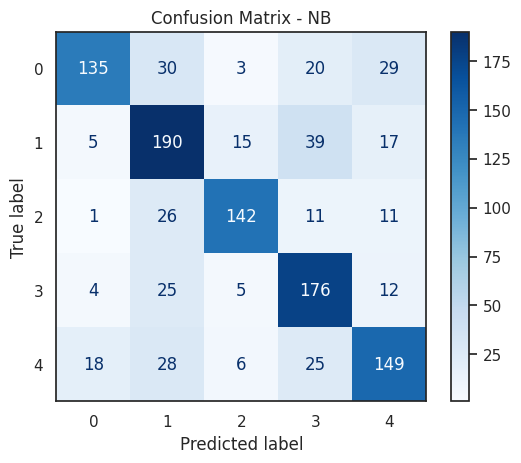

In [ ]:
sns.set_style("white")
cm = confusion_matrix(y_test, y_pred_nb)

# Display the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_nb_model.classes_)
disp.plot(cmap='Blues', values_format='d')

# Show Plot
plt.title("Confusion Matrix - NB")
plt.show()

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Try different k values
k_values = range(2, 80, 5)  # Testing k from 1 to 70
cv_scores = []  # To store cross-validation scores

# Perform cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    scores = cross_val_score(knn, X_train_combined, y_train, cv=5, scoring='accuracy')  # 5-fold CV
    cv_scores.append(scores.mean())

# Find the best k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best k: {best_k}, Cross-Validation Accuracy: {max(cv_scores):.4f}")


Best k: 12, Cross-Validation Accuracy: 0.4907


### SVM

#### SVM RBF

In [ ]:
svm_rbf = svm.SVC(kernel='rbf', C=1, gamma= 'scale', decision_function_shape='ovo')
svm_rbf.fit(X_train_combined, y_train)

# Predict on Test Data
y_pred_rbf = svm_rbf.predict(X_test_combined)

# Evaluate Performance
print("SVM with RBF Accuracy:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))

SVM with RBF Accuracy: 0.7540106951871658
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       217
           1       0.68      0.74      0.71       266
           2       0.88      0.76      0.81       191
           3       0.67      0.79      0.73       222
           4       0.79      0.73      0.76       226

    accuracy                           0.75      1122
   macro avg       0.77      0.75      0.76      1122
weighted avg       0.76      0.75      0.76      1122



In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10, 20, 100],  # Regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# Grid search for best hyperparameters
grid_search = GridSearchCV(svm.SVC(kernel='rbf', decision_function_shape = 'ovo'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_combined, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 20, 'gamma': 'scale'}
Best Accuracy: 0.7603121516164995


In [ ]:
## Best model
best_svm_rbf = svm.SVC(kernel='rbf', C=20, gamma='scale', decision_function_shape='ovo')
best_svm_rbf.fit(X_train_combined, y_train)

y_pred_best_rbf = best_svm_rbf.predict(X_test_combined)
acc_rbf = accuracy_score(y_test, y_pred_best_rbf)


print("SVM Accuracy with Best C:",acc_rbf)
print(classification_report(y_test, y_pred_best_rbf))

SVM Accuracy with Best C: 0.7869875222816399
              precision    recall  f1-score   support

           0       0.84      0.76      0.79       217
           1       0.73      0.77      0.75       266
           2       0.88      0.79      0.83       191
           3       0.71      0.82      0.76       222
           4       0.83      0.80      0.82       226

    accuracy                           0.79      1122
   macro avg       0.80      0.79      0.79      1122
weighted avg       0.79      0.79      0.79      1122



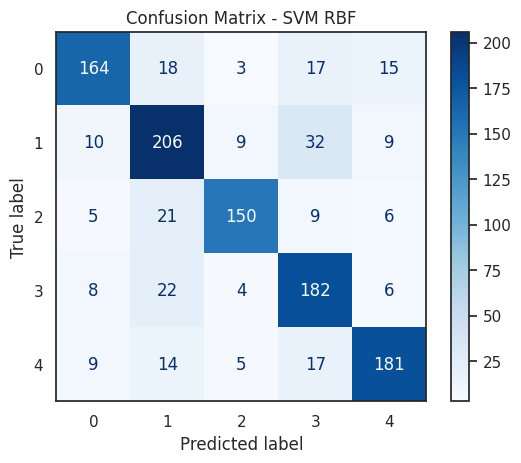

In [ ]:
cm = confusion_matrix(y_test, y_pred_best_rbf)

# Display the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm_rbf.classes_)
disp.plot(cmap='Blues', values_format='d')

# Show Plot
plt.title("Confusion Matrix - SVM RBF")
plt.show()

#### SVM Linear


In [ ]:
from sklearn import svm

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, decision_function_shape='ovo')
SVM.fit(X_train_combined,y_train)

# predict the labels on validation dataset
y_pred_svm = SVM.predict(X_test_combined)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score: ",accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy Score:  0.7477718360071302
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       217
           1       0.70      0.71      0.71       266
           2       0.82      0.76      0.79       191
           3       0.67      0.77      0.72       222
           4       0.78      0.76      0.77       226

    accuracy                           0.75      1122
   macro avg       0.76      0.75      0.75      1122
weighted avg       0.75      0.75      0.75      1122



In [ ]:
## Tuning
param_grid = {'C': [0.01, 0.1, 1, 3, 5, 7]}
grid_search = GridSearchCV(svm.SVC(kernel='linear', decision_function_shape='ovo'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_combined, y_train)

print("Best C:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best C: {'C': 3}
Best Accuracy: 0.738015607580825


In [ ]:
best_svm_model = svm.SVC(C = 3.0, kernel='linear', decision_function_shape='ovo')
best_svm_model.fit(X_train_combined, y_train)

y_pred_best_svm = best_svm_model.predict(X_test_combined)
acc_svm1 = accuracy_score(y_test, y_pred_best_svm)


print("SVM Accuracy with Best C:",acc_svm1)
print(classification_report(y_test, y_pred_best_svm))

SVM Accuracy with Best C: 0.7647058823529411
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       217
           1       0.75      0.73      0.74       266
           2       0.79      0.78      0.79       191
           3       0.72      0.75      0.74       222
           4       0.80      0.78      0.79       226

    accuracy                           0.76      1122
   macro avg       0.77      0.77      0.77      1122
weighted avg       0.77      0.76      0.76      1122



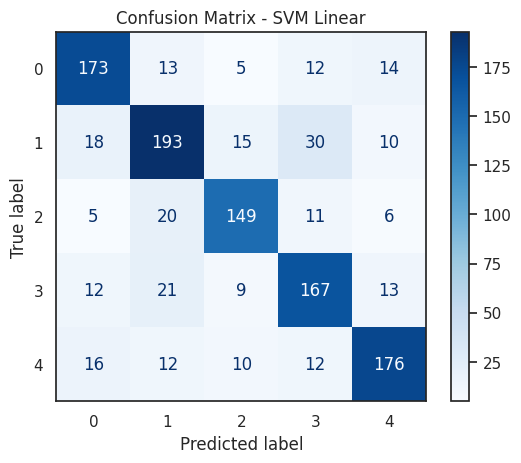

In [ ]:
cm = confusion_matrix(y_test, y_pred_best_svm)

# Display the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm_model.classes_)
disp.plot(cmap='Blues', values_format='d')

# Show Plot
plt.title("Confusion Matrix - SVM Linear")
plt.show()

## Features: BERT and LDA

### Train Test Split

In [ ]:
# Load BERT embeddings from disk
X_bert = np.load("/content/drive/MyDrive/X_bert.npy")
y_bert = np.load("/content/drive/MyDrive/y_bert.npy")

print("Loaded BERT embeddings successfully!")
print("Shape of X_train_bert:", X.shape)
print("Shape of X_test_bert:", y.shape)

Loaded BERT embeddings successfully!
Shape of X_train_bert: (5607, 768)
Shape of X_test_bert: (5607,)


In [ ]:
lda_features

array([[1.00628706e-03, 9.96014893e-01, 9.94102913e-04, 9.90486005e-04,
        9.94183938e-04],
       [4.70222443e-01, 5.28231025e-01, 5.15175867e-04, 5.14158746e-04,
        5.17241016e-04],
       [3.40651631e-01, 5.81721783e-01, 2.56880224e-02, 2.59812474e-02,
        2.59573255e-02],
       ...,
       [2.88512763e-02, 2.87177097e-02, 8.83607149e-01, 2.96087228e-02,
        2.92150956e-02],
       [5.49422391e-03, 5.51116513e-03, 4.11837429e-01, 5.71593344e-01,
        5.56379044e-03],
       [5.07771596e-03, 5.10380138e-03, 5.10745682e-03, 2.83290118e-01,
        7.01420903e-01]])

In [ ]:
X_train_bert, X_test_bert, X_train_lda, X_test_lda, y_train_2, y_test_2 = train_test_split(
    X_bert, lda_features, y_bert, test_size=0.2, random_state=42)

# Standardize Topic Distribution
scaler = MinMaxScaler()

X_train_lda_scaled = scaler.fit_transform(X_train_lda)
X_test_lda_scaled = scaler.transform(X_test_lda)

# Stack Bert and LDA features

X_train_combined_2 = np.hstack([X_train_bert, X_train_lda_scaled])
X_test_combined_2 = np.hstack([X_test_bert, X_test_lda_scaled])

In [ ]:
print("Shape of X_train_bert:", X_train_combined.shape)
print("Shape of X_train_lda:", X_test_combined.shape)

Shape of X_train_bert: (4485, 5005)
Shape of X_train_lda: (1122, 5005)


### SVM

#### SVM Linear

In [ ]:
svm_model_bert2 = svm.SVC(kernel='linear', C= 1, decision_function_shape ='ovo')
svm_model_bert2.fit(X_train_combined_2, y_train_2)

# Predict on Test Data
y_pred_svm2 = svm_model_bert2.predict(X_test_combined_2)
acc_bert_2 = accuracy_score(y_test_2, y_pred_svm2)

# Evaluate Model Performance
print("SVM linear Accuracy with BERT + LDA:", accuracy_score(y_test_2, y_pred_svm2))
print(classification_report(y_test_2, y_pred_svm2))

SVM linear Accuracy with BERT + LDA: 0.6746880570409982
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       217
           1       0.61      0.65      0.63       266
           2       0.65      0.69      0.67       191
           3       0.71      0.68      0.70       222
           4       0.70      0.64      0.67       226

    accuracy                           0.67      1122
   macro avg       0.68      0.68      0.68      1122
weighted avg       0.68      0.67      0.68      1122



In [ ]:
param_grid = {'C': [0.1, 1, 3, 5, 10]}
grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_combined_2, y_train_2)

print("Best C:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

In [ ]:
best_svm_model_bert2_lin = svm.SVC(kernel='linear', C=10, gamma='scale', decision_function_shape='ovo')
best_svm_model_bert2_lin.fit(X_train_combined_2, y_train_2)

y_pred_best_lin_bert = best_svm_model_bert2_lin.predict(X_test_combined_2)
acc_rbf_bert = accuracy_score(y_test_2, y_pred_best_lin_bert)


print("SVM Accuracy with Best C:",acc_rbf_bert)
print(classification_report(y_test_2, y_pred_best_lin_bert))

SVM Accuracy with Best C: 0.6702317290552585
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       217
           1       0.62      0.67      0.64       266
           2       0.65      0.71      0.68       191
           3       0.72      0.69      0.70       222
           4       0.71      0.58      0.64       226

    accuracy                           0.67      1122
   macro avg       0.67      0.67      0.67      1122
weighted avg       0.67      0.67      0.67      1122



#### SVM RBF

In [ ]:
svm_model_bert2_rbf = svm.SVC(kernel='rbf', C=1, gamma = 'scale', decision_function_shape = 'ovo')
svm_model_bert2_rbf.fit(X_train_combined_2, y_train_2)

# Predict on Test Data
y_pred_svm2 = svm_model_bert2_rbf.predict(X_test_combined_2)
acc_bert_4 = accuracy_score(y_test_2, y_pred_svm2)


# Evaluate Model Performance
print("SVM Accuracy with BERT + LDA:", accuracy_score(y_test_2, y_pred_svm2))
print(classification_report(y_test_2, y_pred_svm2))

SVM Accuracy with BERT + LDA: 0.6131907308377896
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       217
           1       0.59      0.65      0.62       266
           2       0.59      0.59      0.59       191
           3       0.64      0.66      0.65       222
           4       0.59      0.62      0.60       226

    accuracy                           0.61      1122
   macro avg       0.62      0.61      0.61      1122
weighted avg       0.62      0.61      0.61      1122



In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 3, 5, 10]
              , 'gamma': ['scale', 'auto', 0.01, 0.1, 1]}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_combined_2, y_train_2)

print("Best C:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best C: {'C': 10, 'gamma': 0.01}
Best Accuracy: 0.6735785953177258


In [ ]:
best_svm_model_bert2_rbf = svm.SVC(kernel='rbf', C=10, gamma=0.01, decision_function_shape='ovo')
best_svm_model_bert2_rbf.fit(X_train_combined_2, y_train_2)

y_pred_best_rbf_bert = best_svm_model_bert2_rbf.predict(X_test_combined_2)
acc_rbf_bert = accuracy_score(y_test_2, y_pred_best_rbf_bert)


print("SVM Accuracy with Best C:",acc_rbf_bert)
print(classification_report(y_test_2, y_pred_best_rbf_bert))

SVM Accuracy with Best C: 0.7130124777183601
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       217
           1       0.67      0.71      0.69       266
           2       0.74      0.71      0.72       191
           3       0.70      0.74      0.72       222
           4       0.71      0.68      0.69       226

    accuracy                           0.71      1122
   macro avg       0.72      0.71      0.71      1122
weighted avg       0.71      0.71      0.71      1122



### KNN (PCA applied on BERT)

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA separately on training BERT embeddings
pca = PCA(n_components=100)
X_train_bert_pca = pca.fit_transform(X_train_bert)  # Fit PCA on training BERT embeddings
X_test_bert_pca = pca.transform(X_test_bert)  # Transform test BERT embeddings using the same PCA

# Combine PCA-reduced BERT embeddings with LDA features
X_train_combined = np.hstack((X_train_bert_pca, X_train_lda_scaled))
X_test_combined = np.hstack((X_test_bert_pca, X_test_lda_scaled))

# Train KNN Model
knn_classifier = KNeighborsClassifier(n_neighbors=65, weights='distance', metric='cosine')
knn_classifier.fit(X_train_combined, y_train_2)

# Predict
y_pred_2 = knn_classifier.predict(X_test_combined)

# Evaluate
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
print("✅ Test Accuracy with PCA + LDA + KNN:", accuracy_2)

# Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test_2, y_pred_2))

✅ Test Accuracy with PCA + LDA + KNN: 0.6506238859180036

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.62      0.67       217
           1       0.62      0.79      0.69       266
           2       0.68      0.58      0.62       191
           3       0.69      0.61      0.65       222
           4       0.59      0.62      0.60       226

    accuracy                           0.65      1122
   macro avg       0.66      0.64      0.65      1122
weighted avg       0.66      0.65      0.65      1122



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the range of k values to test
param_grid = {'n_neighbors': [5, 10, 25, 50, 65, 100]}

# Initialize KNN model
knn = KNeighborsClassifier(weights='distance', metric='cosine')

# Perform GridSearch to find the best k
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train_2)

# Get the best k value
best_k = grid_search.best_params_['n_neighbors']
best_knn_model = grid_search.best_estimator_

# Evaluate on test data
y_pred_2 = best_knn_model.predict(X_test_combined)
accuracy_2 = accuracy_score(y_test_2, y_pred_2)

print("✅ Best k value:", best_k)
print("✅ Test Accuracy with Best k:", accuracy_2)
print("\n📊 Classification Report:\n", classification_report(y_test_2, y_pred_2))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best k value: 50
✅ Test Accuracy with Best k: 0.6470588235294118

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.64       217
           1       0.64      0.77      0.70       266
           2       0.66      0.59      0.62       191
           3       0.71      0.63      0.67       222
           4       0.57      0.61      0.59       226

    accuracy                           0.65      1122
   macro avg       0.65      0.64      0.64      1122
weighted avg       0.65      0.65      0.65      1122



### Random Forest (PCA applied on BERT)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Combine PCA-reduced BERT embeddings with raw LDA features (NO SCALING for RF)
X_train_combined = np.hstack((X_train_bert_pca, X_train_lda))
X_test_combined = np.hstack((X_test_bert_pca, X_test_lda))

# Train Random Forest Model
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_classifier.fit(X_train_combined, y_train_2)

# Predict
y_pred_2 = rf_classifier.predict(X_test_combined)

# Evaluate
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
print("✅ Test Accuracy with PCA + LDA + Random Forest:", accuracy_2)

# Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test_2, y_pred_2))

✅ Test Accuracy with PCA + LDA + Random Forest: 0.679144385026738

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.66      0.73       217
           1       0.64      0.65      0.65       266
           2       0.77      0.64      0.70       191
           3       0.63      0.75      0.69       222
           4       0.63      0.69      0.66       226

    accuracy                           0.68      1122
   macro avg       0.69      0.68      0.68      1122
weighted avg       0.69      0.68      0.68      1122



In [ ]:
# Apply PCA separately on training BERT embeddings
pca = PCA(n_components=100)
X_train_bert_pca = pca.fit_transform(X_train_bert)  # Fit PCA on training BERT embeddings
X_test_bert_pca = pca.transform(X_test_bert)  # Transform test BERT embeddings using the same PCA

# Combine PCA-reduced BERT embeddings with raw LDA features (NO SCALING for RF)
X_train_combined = np.hstack((X_train_bert_pca, X_train_lda))
X_test_combined = np.hstack((X_test_bert_pca, X_test_lda))

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Min samples per split
    'min_samples_leaf': [1, 2, 4]  # Min samples per leaf
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Perform GridSearch
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train_2)

# Get the best model
best_rf = grid_search.best_estimator_

# Predict with the optimized model
y_pred_2 = best_rf.predict(X_test_combined)

# Evaluate the optimized model
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
print("✅ Optimized Test Accuracy with PCA + LDA + Random Forest:", accuracy_2)
print("📌 Best Parameters:", grid_search.best_params_)

# Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test_2, y_pred_2))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Optimized Test Accuracy with PCA + LDA + Random Forest: 0.6925133689839572
📌 Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.65      0.74       217
           1       0.65      0.68      0.67       266
           2       0.79      0.68      0.73       191
           3       0.63      0.76      0.69       222
           4       0.63      0.69      0.66       226

    accuracy                           0.69      1122
   macro avg       0.71      0.69      0.70      1122
weighted avg       0.71      0.69      0.69      1122



## Feature: BERT

### Random Forest

In [ ]:
# Train Random Forest Model (Using default settings initially)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_bert_pca, y_train_2)

# Predict
y_pred_2 = rf_classifier.predict(X_test_bert_pca)

# Evaluate
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
print("✅ Test Accuracy with PCA-Reduced BERT + Random Forest:", accuracy_2)

# Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test_2, y_pred_2))


✅ Test Accuracy with PCA-Reduced BERT + Random Forest: 0.660427807486631

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.61      0.68       217
           1       0.66      0.72      0.69       266
           2       0.60      0.66      0.63       191
           3       0.67      0.65      0.66       222
           4       0.62      0.65      0.63       226

    accuracy                           0.66      1122
   macro avg       0.67      0.66      0.66      1122
weighted avg       0.67      0.66      0.66      1122



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [10, 20, None],       # Tree depth
    'min_samples_split': [2, 5, 10],   # Minimum samples per split
    'min_samples_leaf': [1, 2, 4]      # Minimum samples in a leaf node
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_bert_pca, y_train_2)

# Get the best parameters
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Evaluate the optimized model
y_pred_2 = best_rf_model.predict(X_test_bert_pca)
accuracy_2 = accuracy_score(y_test_2, y_pred_2)

print("✅ Best Hyperparameters for Random Forest:", best_params)
print("✅ Test Accuracy with Best Random Forest Model:", accuracy_2)
print("\n📊 Classification Report:\n", classification_report(y_test_2, y_pred_2))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
✅ Test Accuracy with Best Random Forest Model: 0.6764705882352942

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.64      0.70       217
           1       0.65      0.70      0.67       266
           2       0.64      0.65      0.65       191
           3       0.69      0.68      0.69       222
           4       0.64      0.70      0.67       226

    accuracy                           0.68      1122
   macro avg       0.68      0.67      0.68      1122
weighted avg       0.68      0.68      0.68      1122



# Best Model: SVM RBF with TFIDF and LDA
The best performing model is SVM RBF with TFIDF and LDA. The model outperforms the rest in all categories: accuracy, precision, recall, and F1 score.

SVM Accuracy with Best C: 0.7869875222816399
              precision    recall  f1-score   support

           0       0.84      0.76      0.79       217
           1       0.73      0.77      0.75       266
           2       0.88      0.79      0.83       191
           3       0.71      0.82      0.76       222
           4       0.83      0.80      0.82       226

    accuracy                           0.79      1122
   macro avg       0.80      0.79      0.79      1122
weighted avg       0.79      0.79      0.79      1122



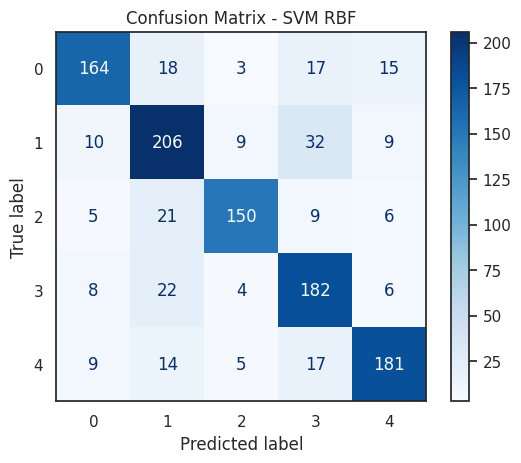

In [ ]:
X_train_combined = hstack([tfidf_train, lda_train_scaled])
X_test_combined = hstack([tfidf_test, lda_test_scaled])

best_svm_rbf = svm.SVC(kernel='rbf', C=20, gamma='scale', decision_function_shape='ovo')
best_svm_rbf.fit(X_train_combined, y_train)

y_pred_best_rbf = best_svm_rbf.predict(X_test_combined)
acc_rbf = accuracy_score(y_test, y_pred_best_rbf)


print("SVM Accuracy with Best C:",acc_rbf)
print(classification_report(y_test, y_pred_best_rbf))

cm = confusion_matrix(y_test, y_pred_best_rbf)

# Display the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm_rbf.classes_)
disp.plot(cmap='Blues', values_format='d')

# Show Plot
plt.title("Confusion Matrix - SVM RBF")
plt.show()

# External Validation
To assess the final model performance on unseen data, we validate the model against a new dataset containing suicidal ideation-related posts.

The validation dataset contains labels indicating suicidal intention levels (e.g., Ideation, Attempt, Behavior), whereas the trained model classifies text into mental health conditions (e.g., Depression, Anxiety, Bipolar Disorder). Applying the model to this dataset allows us to:

* Identify which mental health conditions are most associated with different levels of suicide risk.
* Provide insights into whether certain conditions (e.g., Depression, Bipolar Disorder) appear more frequently in high-risk suicide cases.
* Support suicidal risk assessment models by integrating mental health predictions.

This analysis aims to assess whether our model can accurately classify suicide-related posts and identify their association with mental health conditions strongly linked to suicidal ideation, such as depression and bipolar disorder.


The original dataset can be found here https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red/data

Below is our interpretations of the labels:

* Attempt – Cases where an individual has actually attempted suicide.
* Behavior – Cases where an individual exhibits suicidal behavior (e.g., self-harm, planning suicide, acquiring means to Attempt).
* Ideation – Cases where an individual has suicidal thoughts or ideation but has not taken action.
* Indicator – Cases where there are indicators of potential suicide risk, such as indirect verbal cues or emotional distress.
* Supportive – Cases where individuals show supportive behavior, possibly indicating seeking help, engaging in therapy, or expressing hope despite distress.


## Load dataset

In [ ]:
df_validation = pd.read_csv('/content/drive/MyDrive/500_anonymized_Reddit_users_posts_labels - 500_anonymized_Reddit_users_posts_labels.csv')


In [ ]:
df_validation.head()

,User,Post,Label
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive
1,user-1,['It can be hard to appreciate the notion that...,Ideation
2,user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,user-3,['I tried to kill my self once and failed badl...,Attempt
4,user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


## Data Preprocessing

In [ ]:
df_validation = df_validation.dropna()

In [ ]:
df_validation[['processed_text', 'processed_text_str']] = df_validation['Post'].apply(preprocess_text).apply(pd.Series)
df_validation['processed_text_str'] = df_validation['processed_text_str'].astype(str)

In [ ]:
df_validation['processed_text'] = df_validation['processed_text'].apply(lambda x: x if isinstance(x, list) else [])
print(type(df_validation['processed_text'].iloc[0]))  # Should be <class 'list'>
print(all(isinstance(doc, list) for doc in df_validation['processed_text']))  # Should return True


<class 'list'>
True


## Feature Extraction

In [ ]:
## LDA
dictionary = corpora.Dictionary(df_validation['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df_validation['processed_text']]

lda_model_val = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

lda_features_val = get_lda_features(lda_model_val, corpus, 5)

lda_val_df = pd.DataFrame(lda_features_val, columns=[f"topic_{i}" for i in range(5)])
lda_val_df.index = df_validation.index
df_validation = pd.concat([df_validation, lda_val_df], axis=1)

# Extract LDA topic features
lda_val = df_validation[[f"topic_{i}" for i in range(5)]].values

# Scale LDA features using the same scaler
lda_val_scaled = scaler.transform(lda_val)

In [ ]:
## TFIDF
tfidf_val = tfidf_vectorizer.transform(df_validation['processed_text_str'])

## Perform Prediction Task

In [ ]:
# Combine TF-IDF & Scaled LDA Features
X_val_combined = hstack([tfidf_val, lda_val_scaled])

In [ ]:
y_val_pred = best_svm_rbf.predict(X_val_combined)

# Add predictions to the dataset
df_validation['predicted_target'] = y_val_pred
df_validation.head()


,User,Post,Label,processed_text,processed_text_str,topic_0,topic_1,topic_2,topic_3,topic_4,predicted_target,predicted_category
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive,"[viable, option, youll, leave, wife, behind, y...",viable option youll leave wife behind youd pai...,0.002956,0.003021,0.322956,0.003015,0.668052,4,Depression
1,user-1,['It can be hard to appreciate the notion that...,Ideation,"[hard, appreciate, notion, could, meet, someon...",hard appreciate notion could meet someone else...,0.000207,0.000211,0.997398,0.000211,0.001973,1,Personality disorder
2,user-2,"['Hi, so last night i was sitting on the ledge...",Behavior,"[hi, last, night, sit, ledge, window, contempl...",hi last night sit ledge window contemplate whe...,0.000920,0.000942,0.972801,0.000938,0.024400,0,Personality disorder
3,user-3,['I tried to kill my self once and failed badl...,Attempt,"[try, kill, self, fail, badly, cause, moment, ...",try kill self fail badly cause moment want rea...,0.000492,0.000503,0.012511,0.510160,0.476334,4,Depression
4,user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation,"[hi, nem, sort, thing, enjoy, personally, alwa...",hi nem sort thing enjoy personally always welc...,0.001951,0.001994,0.005465,0.001990,0.988599,0,Depression


In [ ]:
# Map Target values to Mental Health categories

# Mapping dictionary
label_mapping = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar disorder",
    3: "Personality disorder",
    4: "Anxiety"
}

# Apply mapping to predicted labels
df_validation['predicted_category'] = df_validation['predicted_target'].map(label_mapping)

# Display some results
df_validation[['processed_text_str', 'Label', 'predicted_category']].head()


,processed_text_str,Label,predicted_category
0,viable option youll leave wife behind youd pai...,Supportive,Anxiety
1,hard appreciate notion could meet someone else...,Ideation,Depression
2,hi last night sit ledge window contemplate whe...,Behavior,Stress
3,try kill self fail badly cause moment want rea...,Attempt,Anxiety
4,hi nem sort thing enjoy personally always welc...,Ideation,Stress


## Insights

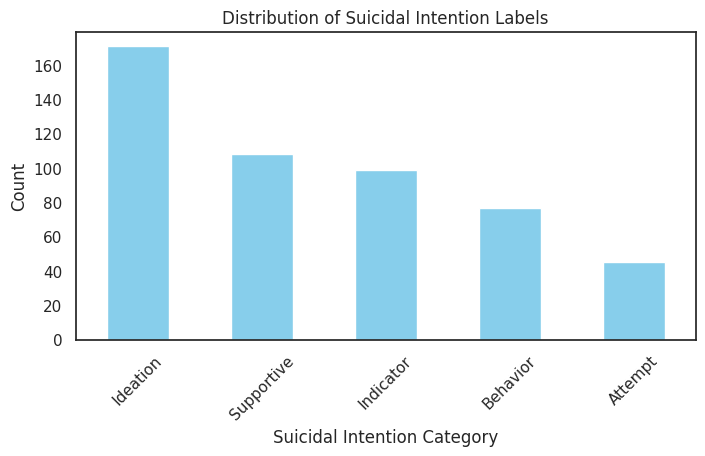

In [ ]:
# Count occurrences of each Suicidal Intention Label
plt.figure(figsize=(8,4))
df_validation['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Suicidal Intention Labels")
plt.xlabel("Suicidal Intention Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


*   Most individuals in the dataset experience suicidal ideation rather than attempts.
* Support-seeking behavior is common, showing a potential opportunity for intervention.
* Understanding warning signs (Indicator & Behavior) could help in early intervention strategies.


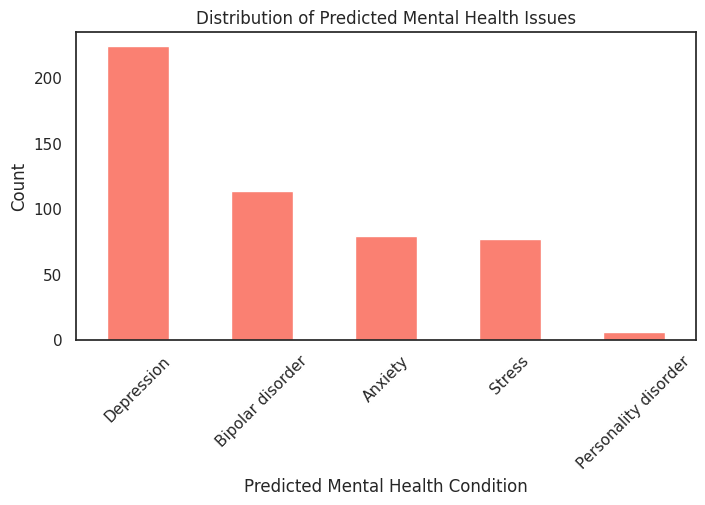

In [ ]:
# Count occurrences of each Predicted Mental Health Issue
plt.figure(figsize=(8,4))
df_validation['predicted_category'].value_counts().plot(kind='bar', color='salmon')
plt.title("Distribution of Predicted Mental Health Issues")
plt.xlabel("Predicted Mental Health Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

* Depression is the dominant condition linked to suicidal risk.
* Bipolar disorder is the second most frequent prediction, reinforcing its strong association with suicidality.
* Anxiety and stress also contribute to mental distress but are less dominant.
* Personality disorders are rarely classified, suggesting either a weak correlation or model limitations.

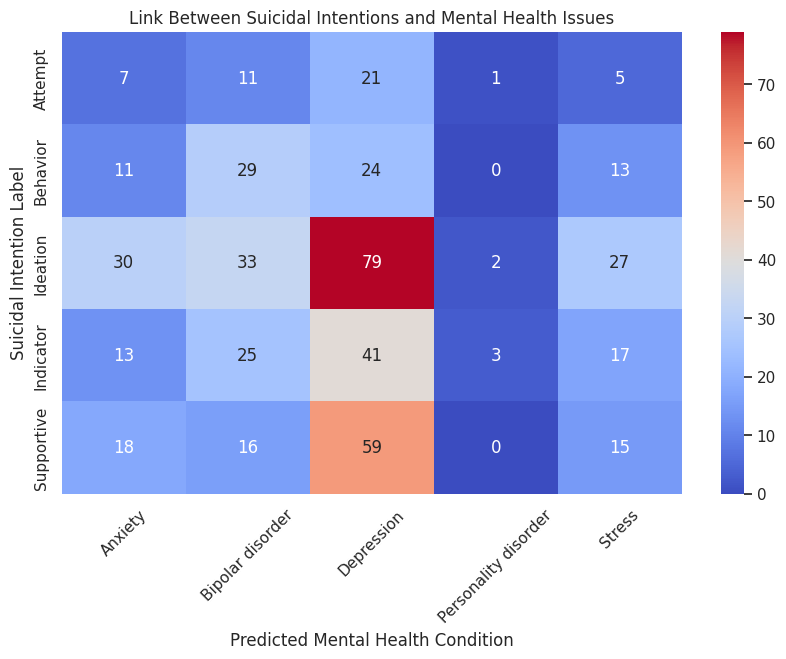

In [ ]:
pivot_table = df_validation.pivot_table(index='Label', columns='predicted_category', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt="d")
plt.title("Link Between Suicidal Intentions and Mental Health Issues")
plt.xlabel("Predicted Mental Health Condition")
plt.ylabel("Suicidal Intention Label")
plt.xticks(rotation=45)
plt.show()

* **Depression** is the dominant predicted condition across different suicide risk levels, especially for Ideation and Supportive indicators. This suggests that suicidal ideation is a common symptom of depression, which aligns with psychological research. In addition, people who struggle with depression also tend to express a need for help, hope, and coping mechanisms (Supportive).
* **Bipolar Disorder** has the second highest associations with suicide risks. Suicidal behaviors, thoughts, and indicators are strongly linked to people with bipolar disorder. This also aligns with research indicating that bipolar disorder has one of the highest suicide attempt rates, often due to extreme mood shifts.
* **Anxiety and Stress** are associated with suicidal risks but to a lesser extent than depression or bipolar disorder.
* The low count for **Personality Disorder** predictions suggests that:
  * The dataset doesn’t link them strongly with suicidal ideation, attempts, or behaviors.
  * OR, the dataset may has fewer personality disorder cases.
